In [7]:
%reload_ext autoreload
%autoreload 2


In [8]:
#1. loads necessary packages

import numpy as np
from scipy import stats
import pandas as pd
import math
import os
from datetime import date
import matplotlib.pyplot as plt

import sys
import csv

from Classes import DataO, MapO, GC




In [9]:
#2. set paths for raw data retreaval and result storing

today = date.today()

# dd/mm/YY
d1 = today.strftime("%d%m%Y")

resultpath="../6_Results/"+d1+"_Maps/"

#writing impact results
rows=[]

In [10]:
#3. Gen thresholds and correlation tables

#### THRESHOLDS #####
from numpy import NaN


thresh_df=pd.DataFrame(
    columns=["Maxtemp",
            "Avgtemp"],
    index= ["Gas",
            "Nuclear",
            "Solar PV",
            "Transformers",
            "Overhead Lines",
            "Demand"]
)

thresh_df['Maxtemp']=[16,20,25,20,23.08,NaN]
thresh_df['Avgtemp']=[NaN,NaN,NaN,NaN,NaN,15]

'TESTING'
print(thresh_df)

#### CORRELATIONS #####
correl_df = pd.DataFrame(
    columns=["Maxtemp",
            "Avgtemp"],
    index= ["Gas",
            "Nuclear",
            "Solar PV",
            "Transformers",
            "Overhead Lines",
            "Demand"]
)

correl_df.loc["Gas","Maxtemp"]= lambda x : 0.7587*x-11.37
correl_df.loc["Nuclear","Maxtemp"]= lambda x : 1.03*(x-20)
correl_df.loc["Solar PV","Maxtemp"]= lambda x : 0.48*(x-25)
correl_df.loc["Transformers","Maxtemp"]= lambda x : 1*(x-20)
correl_df.loc["Overhead Lines","Maxtemp"]= lambda x : 1.3*x-30
correl_df.loc["Demand","Avgtemp"]= lambda x : 3.7*(x-15)

print(correl_df)


                Maxtemp  Avgtemp
Gas               16.00      NaN
Nuclear           20.00      NaN
Solar PV          25.00      NaN
Transformers      20.00      NaN
Overhead Lines    23.08      NaN
Demand              NaN     15.0
                                              Maxtemp  \
Gas             <function <lambda> at 0x7fbd48535790>   
Nuclear         <function <lambda> at 0x7fbd48535700>   
Solar PV        <function <lambda> at 0x7fbd48535670>   
Transformers    <function <lambda> at 0x7fbd485355e0>   
Overhead Lines  <function <lambda> at 0x7fbd48535550>   
Demand                                            NaN   

                                              Avgtemp  
Gas                                               NaN  
Nuclear                                           NaN  
Solar PV                                          NaN  
Transformers                                      NaN  
Overhead Lines                                    NaN  
Demand          <function <lambda

In [11]:
############################## PERIOD 2080-2100 #################################

#4. Initialises Data objects

#setting resolutions

spatial_res=60
time_res='daily'
start_year=2080
finish_year=2099 #finish year is included

#creating result directory
if not os.path.exists(resultpath):
    os.mkdir(resultpath)

#intialising results vctor for plotting
impacts_2080_2099=np.empty((75,6))

#all data objects are created with all available data members in directory (fdpath)
#initialising runs data loading and coordinate vectors loading

Maxtemp=DataO.DataObject(title="60_Daily_Maxtemp_2080_2099_UK",
                        varID="Maxtemp",sres=spatial_res,tres=time_res,syear=start_year,fyear=finish_year,
                        members=12,
                        total_rows=7200,
                        fdpath="../3_Raw_Data/Maxtemp_2080_2099/All",
                        respath=resultpath)

Avgtemp=DataO.DataObject(title="60_Daily_Avgtemp_2080_2099_UK",
                        varID="Avgtemp",sres=spatial_res,tres=time_res,syear=start_year,fyear=finish_year,
                        members=12,
                        total_rows=7200,
                        fdpath="../3_Raw_Data/Avgtemp_2080_2099/All",
                        respath=resultpath)

datao_list=[Maxtemp, Avgtemp]

'TESTING'
for object in datao_list:
    assert object.untreated_array.shape == (12,7170,1,75), 'Loaded data array does not have expected shape'


#5. Statistics test and calculations

Maxtemp.run_stats(KStest=False,stat_source='p90',tp_90=True,tp_10=False)
Avgtemp.run_stats(KStest=False,stat_source='p90',tp_90=True,tp_10=False)

max_temps=[Maxtemp.member_max, Avgtemp.member_max] #collecting each location's max temperature across members

#6. Initlises Map objects and builds max 20y value maps for Maxtemp and Avgtemp
Map_60_Daily_2080_2099=MapO.MapObject_daily(MapID="Maxtemp and Avtemp - max value in 20y",respath=resultpath,coord_dict=Maxtemp.coord_dict)


time_max=np.amax(max_temps[0],axis=0) #max value accross time for each location
ftime_max=time_max.flatten('F')
Map_60_Daily_2080_2099.geojson_props('maxtemp - 20y max',ftime_max)
UK_maxtemps_2080_2099=ftime_max #recovering for restults plotting

time_max=np.amax(max_temps[1],axis=0) #max value accross time for each location
ftime_max=time_max.flatten('F')
Map_60_Daily_2080_2099.geojson_props('avgtemp - 20y max',ftime_max)
UK_avgtemps_2080_2099=ftime_max #recovering for restults plotting

#7. Initialises Grid Component Objects

Gas=GC.GComponent("Gas")
Nuclear=GC.GComponent("Nuclear")
SolarPV=GC.GComponent("Solar PV")
Transf=GC.GComponent("Transformers")
OLines=GC.GComponent("Overhead Lines")
Demand=GC.GComponent("Demand")

component_list=[Gas,Nuclear,SolarPV,Transf,OLines,Demand]

datao_list=[Maxtemp, Avgtemp]

for gc in component_list:
    for wv in datao_list:

        gc.init_thresh(thresh_df)
        gc.init_correl(correl_df,datao_list)
        
        #8. Prompts impact array generation
        thresh=gc.thresholds.loc[wv.varID]
        gc.calc_impacts(thresh,wv)

    fmax_impact_array=gc.impact_arrays["max impact"].flatten('F')
    #print(gc.GCID)
    #print(fmax_impact_array)
    impacts_2080_2099=np.c_[impacts_2080_2099,fmax_impact_array]
    extract_impacts_2080_2099=impacts_2080_2099[:,6:12] #saved for plotting

    #9. writing impact statistics in a results file
    [min, max, avg, p90]=gc.calc_impacts_abs()
    rows.append(["2080-2099", gc.GCID, min, max, avg, p90])

    #10. geojson file generation and writing  
    Map_60_Daily_2080_2099.geojson_props('impact: -'+ gc.GCID + ' ' ,fmax_impact_array)

Map_60_Daily_2080_2099.geojson_write('2080_2099_impacts_max')


no correlation provided for: Gas- variable Avgtemp impact calculation unsuccesful
no correlation provided for: Nuclear- variable Avgtemp impact calculation unsuccesful
no correlation provided for: Solar PV- variable Avgtemp impact calculation unsuccesful
no correlation provided for: Transformers- variable Avgtemp impact calculation unsuccesful
no correlation provided for: Overhead Lines- variable Avgtemp impact calculation unsuccesful
no correlation provided for: Demand- variable Maxtemp impact calculation unsuccesful


In [12]:
############################## PERIOD 2030-2050 #################################

#4. Initialises Data objects

#setting resolutions

spatial_res=60
time_res='daily'
start_year=2030
finish_year=2050 #finish year is included

#creating result directory
if not os.path.exists(resultpath):
    os.mkdir(resultpath)

#intialising results vctor for plotting
impacts_2030_2050=np.empty((75,6))

#all data objects are created with all available data members in directory (fdpath)
#initialising runs data loading and coordinate vectors loading

Maxtemp=DataO.DataObject(title="60_Daily_Maxtemp_2030_2050_UK",
                        varID="Maxtemp",sres=spatial_res,tres=time_res,syear=start_year,fyear=finish_year,
                        members=12,
                        total_rows=7560,
                        fdpath="../3_Raw_Data/Maxtemp_2030_2050/All",
                        respath=resultpath)

Avgtemp=DataO.DataObject(title="60_Daily_Avgtemp_2030_2050_UK",
                        varID="Avgtemp",sres=spatial_res,tres=time_res,syear=start_year,fyear=finish_year,
                        members=12,
                        total_rows=7560,
                        fdpath="../3_Raw_Data/Avgtemp_2030_2050/All",
                        respath=resultpath)

datao_list=[Maxtemp, Avgtemp]

'TESTING'
for object in datao_list:
    assert object.untreated_array.shape == (12,7560,1,75), 'Loaded data array does not have expected shape'


#5. Statistics test and calculations

Maxtemp.run_stats(KStest=False,stat_source='p90',tp_90=True,tp_10=False)
Avgtemp.run_stats(KStest=False,stat_source='p90',tp_90=True,tp_10=False)

max_temps=[Maxtemp.member_max, Avgtemp.member_max] #collecting each location's max temperature across members

#6. Initlises Map objects and builds max 20y value maps for Maxtemp and Avgtemp
Map_60_Daily_2030_2050=MapO.MapObject_daily(MapID="Maxtemp and Avtemp - max value in 20y",respath=resultpath,coord_dict=Maxtemp.coord_dict)


time_max=np.amax(max_temps[0],axis=0) #maximum value accross time for each location
ftime_max=time_max.flatten('F')
Map_60_Daily_2030_2050.geojson_props('maxtemp - 20y max',ftime_max)
UK_maxtemps_2030_2050=ftime_max #recovering for restults plotting

time_max=np.amax(max_temps[1],axis=0) #maximum value accross time for each location
ftime_max=time_max.flatten('F')
Map_60_Daily_2030_2050.geojson_props('avgtemp - 20y max',ftime_max)
UK_avgtemps_2030_2050=ftime_max #recovering for restults plotting


#7. Initialises Grid Component Objects

Gas=GC.GComponent("Gas")
Nuclear=GC.GComponent("Nuclear")
SolarPV=GC.GComponent("Solar PV")
Transf=GC.GComponent("Transformers")
OLines=GC.GComponent("Overhead Lines")
Demand=GC.GComponent("Demand")


component_list=[Gas,Nuclear,SolarPV,Transf,OLines,Demand]

datao_list=[Maxtemp, Avgtemp]

for gc in component_list:
    for wv in datao_list:

        gc.init_thresh(thresh_df)
        gc.init_correl(correl_df,datao_list)
        
        #8. Prompts impact array generation
        thresh=gc.thresholds.loc[wv.varID]
        gc.calc_impacts(thresh,wv)

    fmax_impact_array=gc.impact_arrays["max impact"].flatten('F')
    impacts_2030_2050=np.c_[impacts_2030_2050,fmax_impact_array]
    extract_impacts_2030_2050=impacts_2030_2050[:,6:] #saved for plotting
        
    Map_60_Daily_2030_2050.geojson_props('impact: -'+ gc.GCID + ' ' ,fmax_impact_array)


    #9. writing impact statistics in a results file
    [min, max, avg, p90]=gc.calc_impacts_abs()
    rows.append(["2030-2050", gc.GCID, min, max, avg, p90])
    #10. geojson file generation and writing  
    Map_60_Daily_2030_2050.geojson_props('impact: -'+ gc.GCID + ' ' ,fmax_impact_array)

#10. geojson file generation and writing  
Map_60_Daily_2030_2050.geojson_write('2030_2050_impact_max')


no correlation provided for: Gas- variable Avgtemp impact calculation unsuccesful
no correlation provided for: Nuclear- variable Avgtemp impact calculation unsuccesful
no correlation provided for: Solar PV- variable Avgtemp impact calculation unsuccesful
no correlation provided for: Transformers- variable Avgtemp impact calculation unsuccesful
no correlation provided for: Overhead Lines- variable Avgtemp impact calculation unsuccesful
no correlation provided for: Demand- variable Maxtemp impact calculation unsuccesful


In [13]:
####### SAVING RESULTS IN CSV #####

# name of csv file 
from operator import concat


filename = concat(resultpath,"MinMaxAvg_Impacts.csv")

# field names 
fields = ['Period', "Grid Component", 'Min', 'Max', 'Avg', 'p90'] 

# writing to csv file 
with open(filename, 'w') as csvfile: 
    # creating a csv writer object 
    csvwriter = csv.writer(csvfile) 
        
    # writing the fields 
    csvwriter.writerow(fields) 
        
    # writing the data rows 
    csvwriter.writerows(rows)

In [14]:
####### PLOTTING RESULTS #####

toplot=np.zeros((75,16))
# recovering maxtemps and avgtemps for both periods
toplot[:,0]=UK_maxtemps_2030_2050
toplot[:,1]=UK_avgtemps_2030_2050

toplot[:,8]=UK_maxtemps_2080_2099
toplot[:,9]=UK_avgtemps_2080_2099

# recovering impacts accross UK for both periods, results are contained in each GC's impact arrays
toplot[:,2:8]=extract_impacts_2030_2050
toplot[:,10:16]=extract_impacts_2080_2099


Text(0.5, 1.0, 'temperatures 2080-2099')

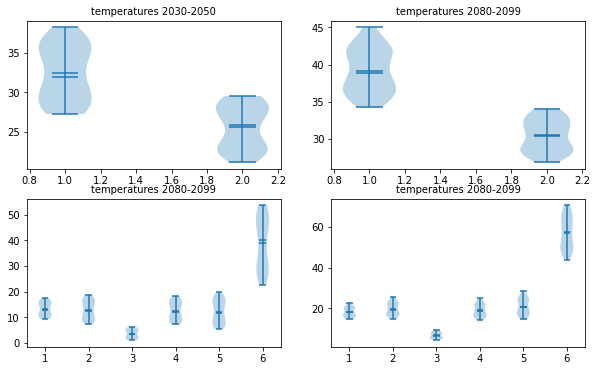

In [15]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))
fs=10


axs[0, 0].violinplot(toplot[:,0:2], points=100, widths=0.3,
                     showmeans=True, showextrema=True, showmedians=True,  bw_method='silverman')
axs[0, 0].set_title('temperatures 2030-2050', fontsize=fs)

axs[0, 1].violinplot(toplot[:,8:10], points=100, widths=0.3,
                     showmeans=True, showextrema=True, showmedians=True, bw_method='silverman')
axs[0, 1].set_title('temperatures 2080-2099', fontsize=fs)

axs[1, 0].violinplot(toplot[:,2:8], points=100, widths=0.3,
                     showmeans=True, showextrema=True, showmedians=True, bw_method='silverman')
axs[1, 0].set_title('temperatures 2080-2099', fontsize=fs)
axs[1, 1].violinplot(toplot[:,10:16], points=100, widths=0.3,
                     showmeans=True, showextrema=True, showmedians=True, bw_method='silverman')
axs[1, 1].set_title('temperatures 2080-2099', fontsize=fs)


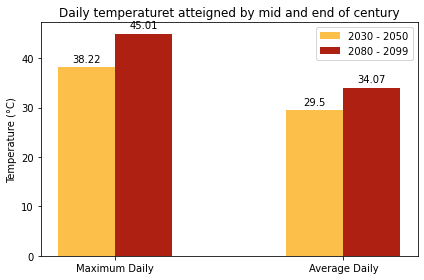

In [16]:

labels = ['Maximum Daily', 'Average Daily']
max1=np.round(np.max(UK_maxtemps_2030_2050),2)
max2=np.round(np.max(UK_maxtemps_2080_2099),2)
avg1=np.round(np.max(UK_avgtemps_2030_2050),2)
avg2=np.round(np.max(UK_avgtemps_2080_2099),2)
men_means = [max1, avg1]
women_means = [max2, avg2]

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, men_means, width, label='2030 - 2050', color='#fcbf49')
rects2 = ax.bar(x + width/2, women_means, width, label='2080 - 2099', color='#ae2012')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Temperature (°C)')
ax.set_title('Daily temperaturet atteigned by mid and end of century')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()


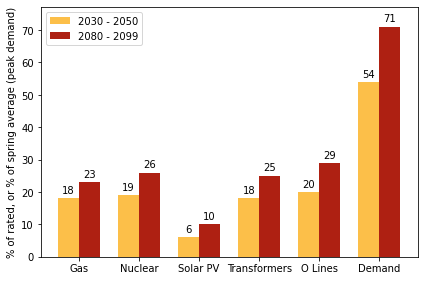

In [18]:
labels = ['Gas', 'Nuclear', 'Solar PV', 'Transformers', 'O Lines', 'Demand']
men_means = [18, 19, 6, 18, 20, 54]
women_means = [23, 26, 10, 25, 29, 71]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, men_means, width, label='2030 - 2050', color='#fcbf49')
rects2 = ax.bar(x + width/2, women_means, width, label='2080 - 2099',  color='#ae2012')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('% of rated, or % of spring average (peak demand)')
#ax.set_title('Capacity decrease in % of rated, or peak load increase in  % of spring average (peak demand)')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
plt.ylim([0, 77])

fig.tight_layout()

plt.show()